# Проект "Рынок заведений общественного питания Москвы".

Цель: выяснить, имеет ли смысл открывать общепит с роботами. Для достижения цели нужно выполнить следующие задачи:
- предобработать данные;
- проанализировать их;
- сформулировать выводы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from io import BytesIO
import requests
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('rest_data.csv')

## Предобработка данных

Изучим датасеты.

In [3]:
data.info()
data.tail(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
15351,223036,Якитория,да,ресторан,"город Москва, Авиационная улица, дом 66",92
15352,213602,Тануки,да,кафе,"город Москва, Привольная улица, дом 65/32",50
15353,213772,Тануки,да,ресторан,"город Москва, Осенний бульвар, дом 9",98
15354,210400,Шоколадница,да,кафе,"город Москва, Театральный проезд, дом 5, строе...",45
15355,74972,Шоколадница,да,кафе,"город Москва, улица Новый Арбат, дом 13",30
15356,220618,Шоколадница,да,кафе,"город Москва, Митинская улица, дом 36, корпус 1",100
15357,218692,Шоколадница,да,кафе,"город Москва, площадь Джавахарлала Неру, дом 1",30
15358,213724,Шоколадница,да,кафе,"город Москва, Варшавское шоссе, дом 87Б",54
15359,222077,Кофейня «Шоколадница»,да,кафе,"город Москва, Кантемировская улица, дом 47",72
15360,219759,Шоколадница,да,кафе,"город Москва, улица Вавилова, дом 3",36


Проверим на пропуски.

In [4]:
data.isna().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

Пропусков нет, проверим на повторы.

In [5]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 840.3+ KB


На всякий случай поищем повторы, исключив столбец id.

In [6]:
data_temp = data.drop(['id'], axis = 1)
data_temp.duplicated().sum()

82

82 повтора можно проигнорировать - это незначительное число в контексте всех данных. Посмотрим, сколько уникальных названий в столбце object_name.

In [7]:
data['object_name'].nunique()

10393

Приведём все названия к нижнему регистру и посмотрим, как это повлияет.

In [8]:
data['object_name'] = data['object_name'].str.lower()
data['object_name'].nunique()

9924

Сразу видно, что кол-во уникальных названий уменьшилось. Это говорит о том, что были идентичные названия, различающиеся лишь регистром. Однако часто в таблице попадаются одни и те же заведения, только в одном случае написано название, а в другом перед названием есть слово "кафе" или "ресторан" или нечто похожее. Раз у нас почти 10 000 уникальных названий, мы не будем сильно заморачиваться - ибо это было бы неоправданная потеря времени - и просто уберём эти слова, составив заранее словарь с наиболее часто встречающимися словами.

In [9]:
dict = {'кафе «', '«', '»', 'кофейня «', 'ресторан', 'закусочная', 'предприятие быстрого питания', 'пбо'}
data['object_name'] = data['object_name'].replace(to_replace = dict, value = '', regex = True)
data.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [10]:
data['object_name'].nunique()

9829

Прекрасно, мы избавились ещё от нескольких сотен дубликатов. Для самых очевидных общепитов изменим значение столбца object_type на "предприятие быстрого обслуживания".

In [11]:
name_dict = {'бургер кинг', 'макдоналдс', 'kfc', 'теремок'}
for i in name_dict:
    data.loc[data['object_name'] == i, 'object_name'] = data[data['object_type'] == 'предприятие быстрого обслуживания']

Финальное действие перед основной задачей: заменим в столбце chain значения на более очевидные для удобства при дальнейшей работе.

In [12]:
data['chain'] = data['chain'].replace({'да': 'сетевое', 'нет': 'несетевое'})

Посмотрим на наш датасет и приступим к основной части.

In [13]:
data.info()
data.sample(15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15179 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 840.3+ KB


,id,object_name,chain,object_type,address,number
7758,71453,кулинарная лавка братьев караваевых,сетевое,кафетерий,"город Москва, Варшавское шоссе, дом 9, строени...",30
2082,158192,азбука вкуса,несетевое,кафе,"город Москва, Новокузнецкая улица, дом 1, стро...",10
6286,26297,андерсен,несетевое,ресторан,"город Москва, улица Обручева, дом 30/1, строен...",165
8496,152897,папа джонс,сетевое,кафе,"город Москва, поселение Сосенское, Калужское ш...",5
195,149531,"шаурма, куры-гриль",несетевое,предприятие быстрого обслуживания,"город Москва, 2-я Владимирская улица, дом 44/10",0
12089,188701,wok & box,сетевое,предприятие быстрого обслуживания,"город Москва, Фестивальная улица, дом 2Б",0
10042,171942,дядюшка хо,несетевое,кафе,"город Москва, Большая Семёновская улица, дом 2...",10
5013,144757,антикафе белый лист,несетевое,кафе,"город Москва, Валовая улица, дом 32/75, строен...",40
1659,28780,столовая школа уна,несетевое,столовая,"город Москва, улица Молодцова, дом 2Б",90
7335,23682,кафе баваро,несетевое,кафе,"город Москва, Нагатинская улица, дом 1, строен...",42


## Анализ данных

### Исследуем соотношение видов объектов общественного питания по количеству

Сгруппируем датасет по столбцу object_type и посчитаем число каждого вида общепита.

In [14]:
object_type_total = data.groupby('object_type')['id'].count().reset_index().sort_values(by='id', ascending=False)
object_type_total

,object_type,id
3,кафе,6099
8,столовая,2587
7,ресторан,2285
6,предприятие быстрого обслуживания,1923
0,бар,856
1,буфет,585
4,кафетерий,398
2,закусочная,360
5,магазин (отдел кулинарии),273


Построим график.

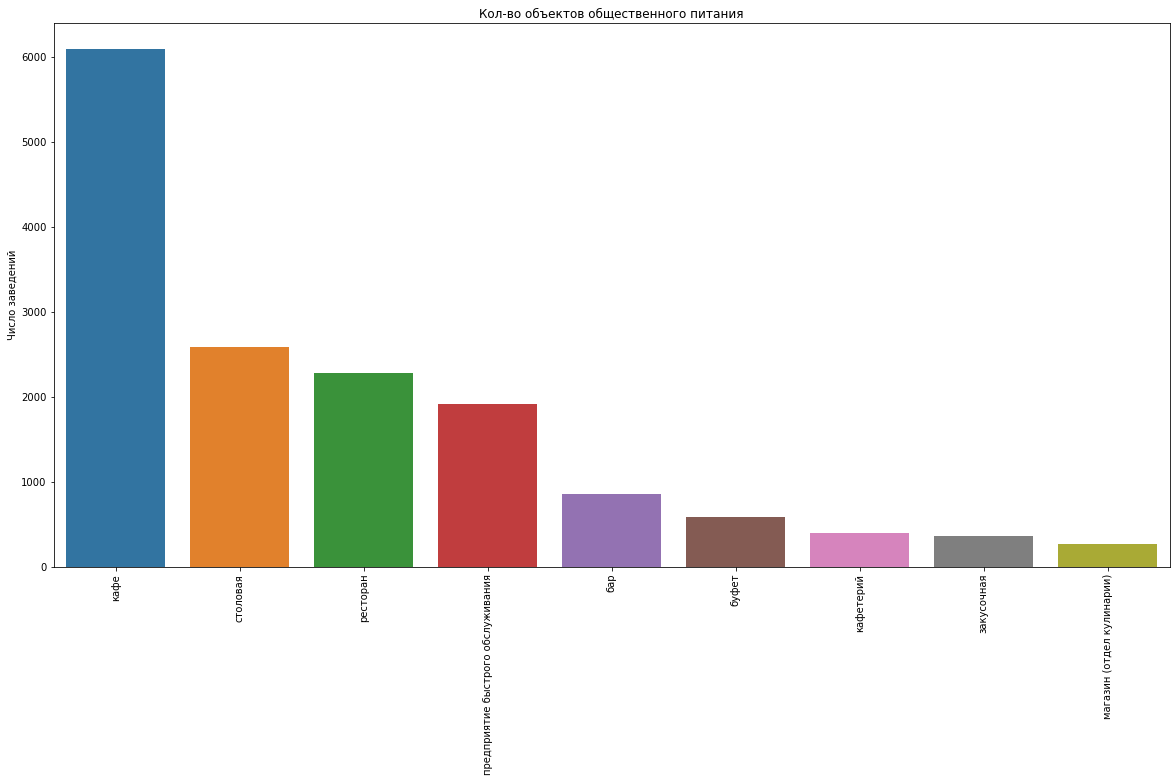

In [15]:
plt.figure(figsize=(20, 10))
sns.barplot(data=object_type_total, x='object_type', y='id')
plt.xticks(rotation=90)
plt.title('Кол-во объектов общественного питания')
plt.xlabel('')
plt.ylabel('Число заведений')
plt.show()

Согласно графику, по количеству заведений лидирует кафе - их по Москве около 6 000. Количество столовых, ресторанов и предприятий быстрого облуживания более чем в два раза меньше, чем кафе. Меньше всего общепитов в магазинах.

### Исследуем соотношение сетевых и несетевых заведений по количеству

Узнаем соотношение, сгруппировав датасет по столцу chain и посчитав кол-во сетевых и несетевых заведений.

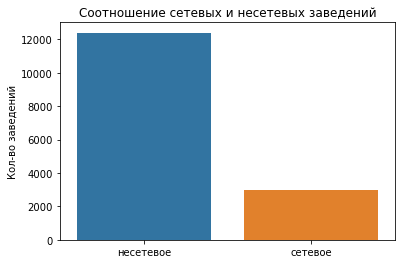

In [16]:
chain_total = data.groupby('chain')['id'].count().reset_index().sort_values(by='id', ascending=False)
sns.barplot(data = chain_total, x='chain', y='id')
plt.xlabel('')
plt.ylabel('Кол-во заведений')
plt.title('Соотношение сетевых и несетевых заведений')
plt.show()

Хотя может предполагаться, что должны лидировать сетевые заведения - те же маки и бургер кинги - данные показывают обратное. Похоже, единичные кафе и шаурмячные серьёзно превосходят числом сетевые заведения. Возможно, несетевые заведения требуют меньше сил и средств для открытия.

### Для какого вида объекта общественного питания характерно сетевое распространение?

Вычислим долю сетевых и несетевых общепитов и построим графики.

In [17]:
data2 = data.pivot_table(index='object_type', columns='chain', values='number', aggfunc='count').reset_index()
data2['total'] = data2['сетевое'] + data2['несетевое']
data2['proportion_yes'] = (data2['сетевое'] / data2['total']) * 100
data2['proportion_no'] = (data2['несетевое'] / data2['total']) * 100
data2

chain,object_type,несетевое,сетевое,total,proportion_yes,proportion_no
0,бар,819,37,856,4.322430,95.677570
1,буфет,574,11,585,1.880342,98.119658
2,закусочная,304,56,360,15.555556,84.444444
3,кафе,4703,1396,6099,22.888998,77.111002
4,кафетерий,346,52,398,13.065327,86.934673
5,магазин (отдел кулинарии),195,78,273,28.571429,71.428571
6,предприятие быстрого обслуживания,1132,791,1923,41.133645,58.866355
7,ресторан,1741,544,2285,23.807440,76.192560
8,столовая,2584,3,2587,0.115964,99.884036


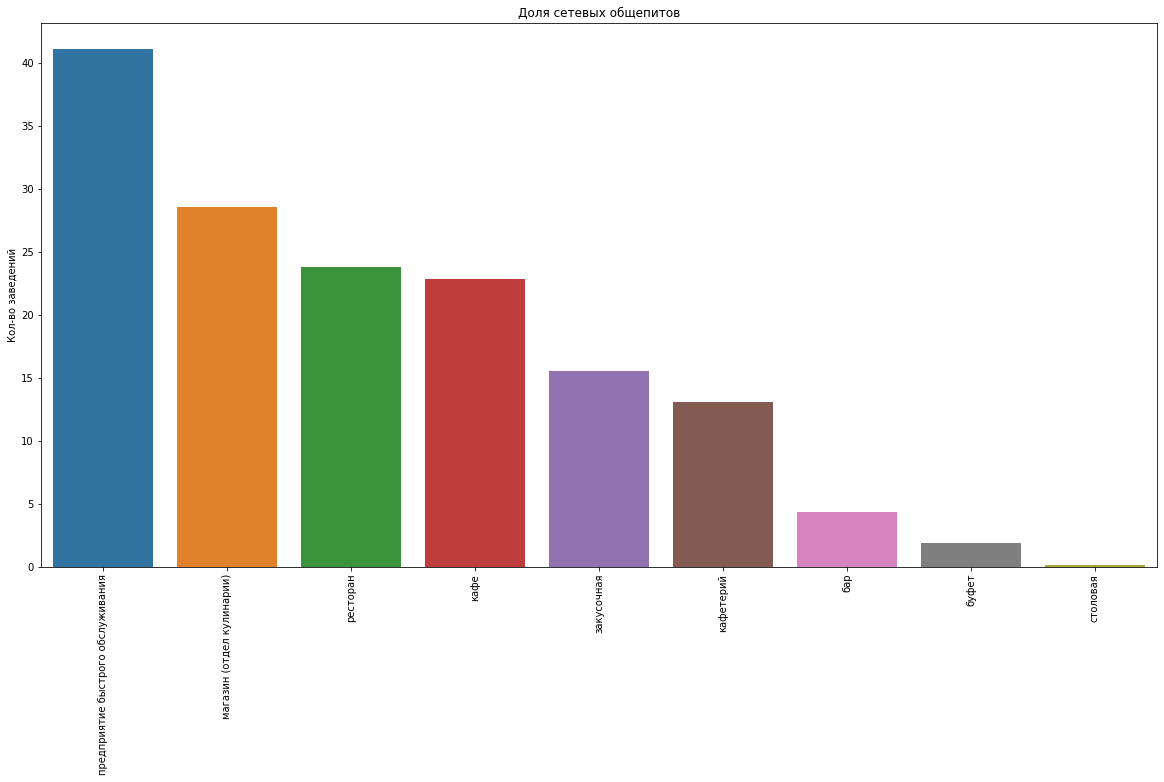

In [18]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
sns.barplot(data=data2.sort_values(by='proportion_yes', ascending=False) , x='object_type', y='proportion_yes')
plt.title('Доля сетевых общепитов')
plt.xlabel('')
plt.ylabel('Кол-во заведений')
plt.show()

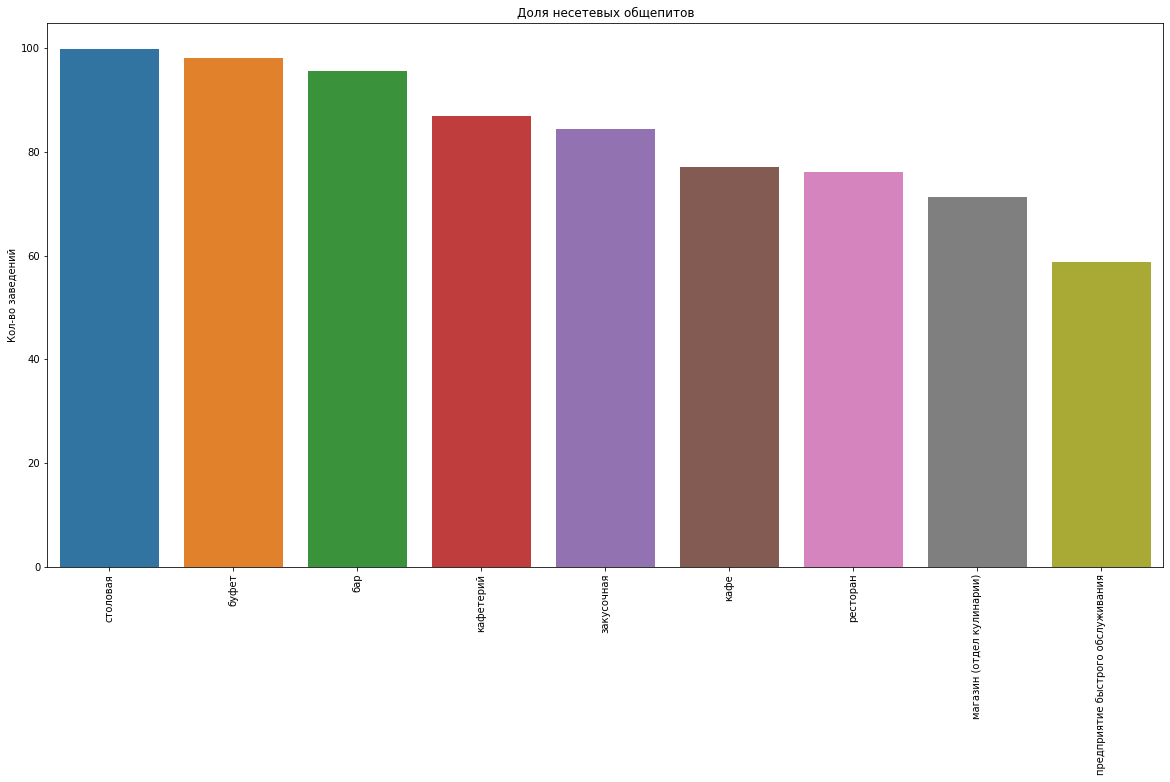

In [19]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
sns.barplot(data=data2.sort_values(by='proportion_no', ascending=False) , x='object_type', y='proportion_no')
plt.title('Доля несетевых общепитов')
plt.xlabel('')
plt.ylabel('Кол-во заведений')
plt.show()

Среди сетевых общепитов лидируют предприятия быстрого питания.

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Для того, чтобы ответить на поставленный вопрос, нужно понять, сколько именно посадочных мест понимается под "небольшим числом", и сколько - под "большим". Для этого построим "ящик с усами" по данным всех заведений и посмотрим кол-во выборосов.

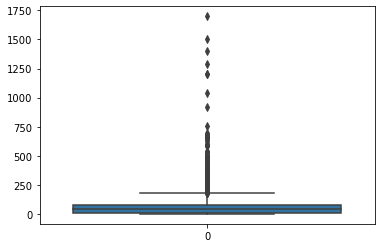

In [20]:
sns.boxplot(data=data['number'])
plt.show()

Видим, что выбросы существенны - есть места общепита с более чем 1500 посадочных мест. Посчитаем перцентили. Т.к. "разбег" большой, посчитаем 75, 95 и 99 процентов.

In [21]:
np.percentile(data['number'], [75, 95, 99])

array([ 80., 214., 300.])

Выберем в качестве "разделителя" 75% - это 80 посадочных мест. Всё, что меньше 80, будем считать заведениями с небольшим числом посадочных мест, а что больше 80 - с большим. Применим это к датасету chain, в котором есть только сетевые заведения.

In [22]:
chain = data[data['chain'] == 'сетевое'].reset_index()
chain['number_type'] = ['small' if x <= 80 else 'big' for x in chain['number']]
chain['number_type'].value_counts()

small    2336
big       632
Name: number_type, dtype: int64

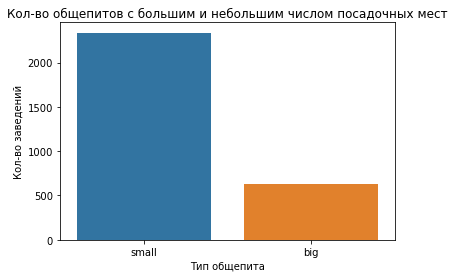

In [23]:
sns.barplot(data = chain['number_type'].value_counts().reset_index(), x='index', y='number_type')
plt.title('Кол-во общепитов с большим и небольшим числом посадочных мест')
plt.xlabel('Тип общепита')
plt.ylabel('Кол-во заведений')
plt.show()

График однозначно показывает, что существенно преобладают заведения с небольшим числом посадачных мест - их 2336 против 632 заведений с большим числом посадочных мест. Попробуем посмотреть на это несколько иначе. Построим гистограмму по распределению посадочных мест среди сетевых заведений.

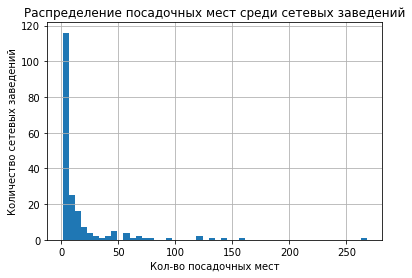

In [24]:
chain['number'].value_counts().hist(bins=50)
plt.title('Распределение посадочных мест среди сетевых заведений')
plt.xlabel('Кол-во посадочных мест')
plt.ylabel('Количество сетевых заведений')
plt.show()

Гистограмма показывает, что преобладают сетевые заведения без посадочных мест. Быть может, это палатки с шаурмой? Или фастфуды на фудкортах ТЦ? В любом случае, картина аналогична предыдущей: с небольшим кол-вом мест сетевых заведений больше, чем с большим.

### Для каждого вида объекта общественного питания опишем среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест?

Сгруппируем изначальный датасет, найдём среднее кол-во посадочных мест и построим график.

In [25]:
mean_number = data.groupby('object_type')['number'].mean().reset_index().sort_values(by='number', ascending=False)
mean_number

,object_type,number
8,столовая,130.246618
7,ресторан,96.834136
1,буфет,51.129915
0,бар,43.494159
3,кафе,39.716019
6,предприятие быстрого обслуживания,20.552262
4,кафетерий,9.123116
2,закусочная,7.608333
5,магазин (отдел кулинарии),5.589744


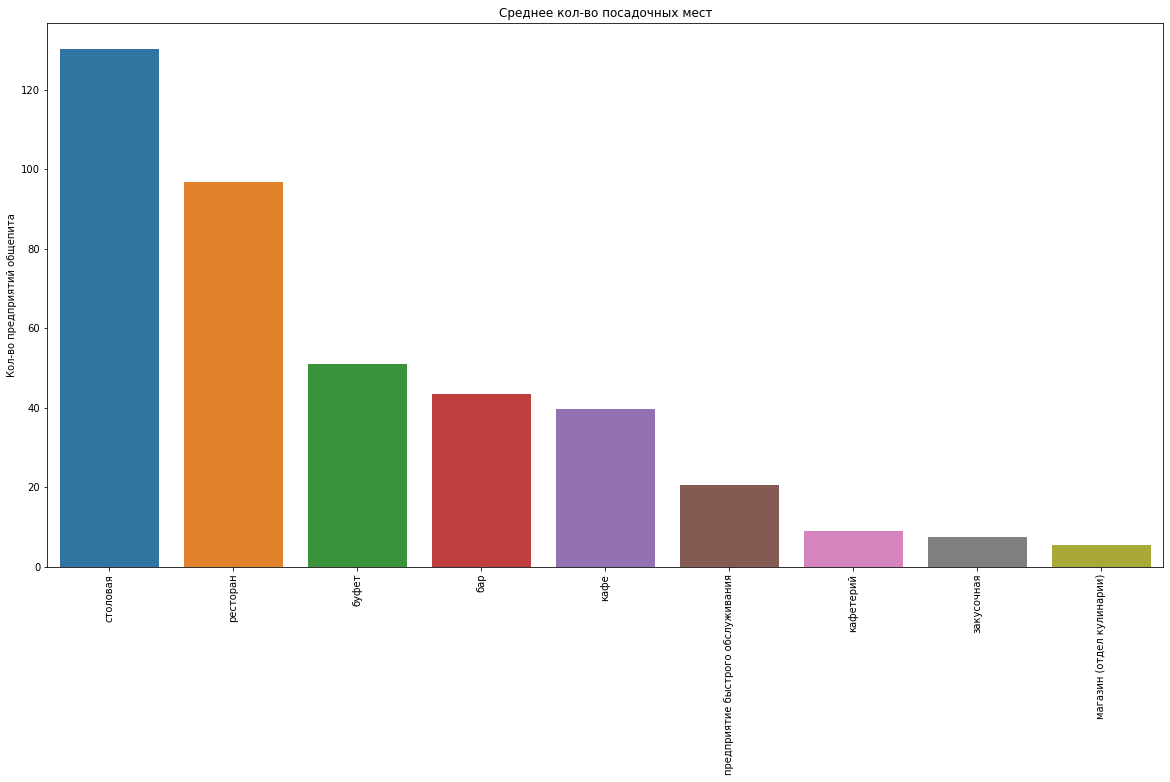

In [26]:
plt.figure(figsize=(20, 10))
sns.barplot(data=mean_number, x='object_type', y='number')
plt.xticks(rotation=90)
plt.title('Среднее кол-во посадочных мест')
plt.xlabel('')
plt.ylabel('Кол-во предприятий общепита')
plt.show()

В среднем, больше всего посадочных мест в столовых, что не расходится со здравым смыслом. Немного удивили предприятия общественного питания, к которым мы отнесли Макдональдсы, Бургер Кинги и т.п. - они занимают 7 место. Впрочем, по-видимому, число посадочных мест сильно различается от места к месту, потому среднее значение оказалось невелико. Замыкает рейтинг магазины, что вполне предсказуемо.

### Выделим в отдельный столбец информацию об улице из столбца address.

Создадим дополнительный столбец street, в который сохранил только название улиц из столба address.

In [27]:
words = {'улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия'}
str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))
data['street'] = data['address'].str.extract(str_pat, flags=re.I)

In [28]:
data

,id,object_name,chain,object_type,address,number,street
0,151635,сметана,несетевое,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,родник,несетевое,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,кафе академия,несетевое,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,пиццетория,сетевое,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,кафе вишневая метель,несетевое,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица
...,...,...,...,...,...,...,...
15361,208537,шоколадница,сетевое,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50,3-й Крутицкий переулок
15362,209264,шоколадница,сетевое,кафе,"город Москва, улица Земляной Вал, дом 33",10,улица Земляной Вал
15363,209186,шоколадница,сетевое,кафе,"город Москва, улица Земляной Вал, дом 33",20,улица Земляной Вал
15364,221900,шоколадница,сетевое,кафе,"город Москва, поселение Московский, Киевское ш...",36,Киевское шоссе


Всё получилось, идём дальше.

### Построим график топ-10 улиц по количеству объектов общественного питания. Воспользуемся внешней информацией, чтобы понять, в каких районах Москвы находятся эти улицы?

Применим группировку к изначальному датасету и сохраним результат в переменной top10. Построим график.

In [29]:
object_name_count = data.groupby('street')['object_name', 'number'].count().reset_index().sort_values(by='object_name', ascending=False)

In [30]:
top10 = object_name_count.head(10)
top10

,street,object_name,number
1418,проспект Мира,202,204
1009,Профсоюзная улица,174,182
683,Ленинградский проспект,166,171
993,Пресненская набережная,164,167
397,Варшавское шоссе,163,164
686,Ленинский проспект,142,147
1414,проспект Вернадского,132,132
673,Кутузовский проспект,113,114
596,Каширское шоссе,112,112
603,Кировоградская улица,109,110


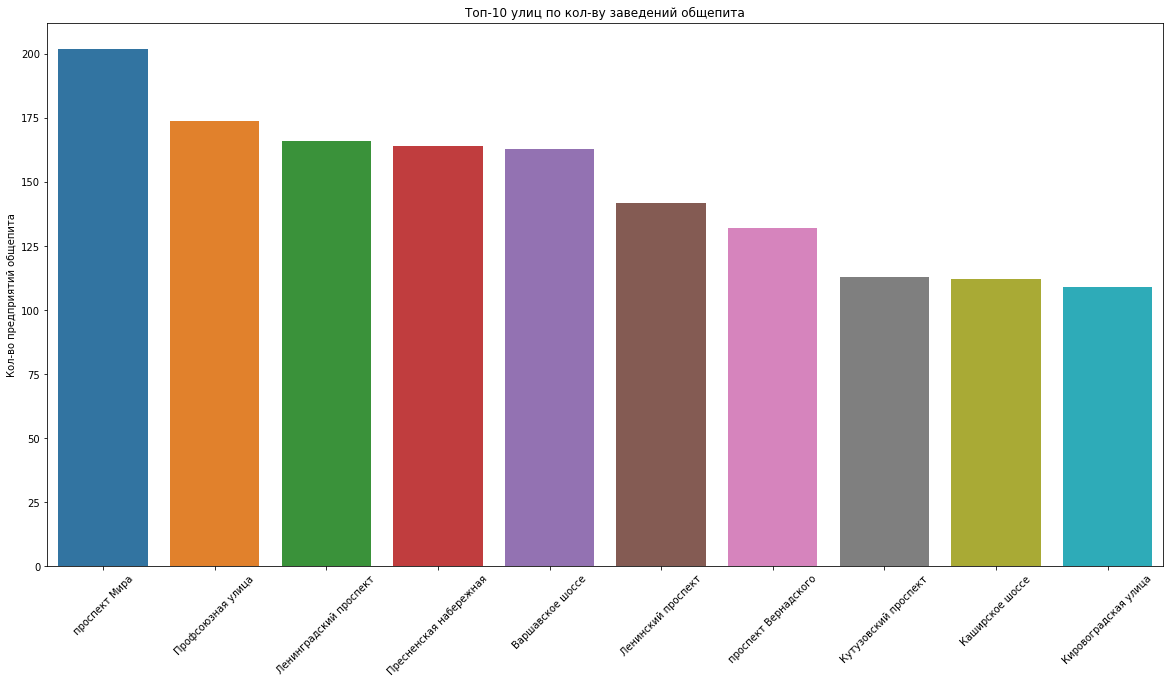

In [31]:
plt.figure(figsize=(20, 10))
sns.barplot(data=top10, x='street', y='object_name')
plt.xticks(rotation=45)
plt.title('Топ-10 улиц по кол-ву заведений общепита')
plt.xlabel('')
plt.ylabel('Кол-во предприятий общепита')
plt.show()

Лидирует проспект Мира, что неудивительно - он очень длинный (целых 8,9 км!), поэтому на нём располагаются аж 202 общепита. В хвосте Кировоградская улица - на ней 109 заведений.

Воспользуемся найденной в сети таблицей с информацией об улицах Москвы, импортируем её в гугл-таблицы и загрузим сюда.

In [32]:
spreadsheet_id = '1fH6ehueXLdiqi49D2n2zEA4RuBRcaH2SWILuMr-qzfA'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
streets = pd.read_csv(BytesIO(r.content))
streets.columns = ['street', 'area_id', 'district', 'area']
streets

,street,area_id,district,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


Смерджим таблицы top10 и таблицу, полученную "извне".

In [33]:
top10 = top10.merge(streets, on='street', how='left')

Построим сводную таблицу, чтобы посмотреть районы.

In [34]:
top10_pivot = top10.pivot_table(index=['street', 'district', 'area'], 
                  values='object_name', 
                  aggfunc='max').sort_values(by='object_name', ascending=False)
top10_pivot

object_name
street                 district area                                        
проспект Мира          ЦАО      Мещанский район                          202
                       СВАО     Ярославский Район                        202
                                Район Свиблово                           202
                                Район Ростокино                          202
                                Район Марьина роща                       202
                                Останкинский район                       202
                                Алексеевский район                       202
Профсоюзная улица      ЮЗАО     Район Коньково                           174
                                Академический район                      174
                                Обручевский район                        174
                                Район Черемушки                          174
                                Район Теплый Стан                        174
                                Район Ясенево                            174
Ленинградский проспект САО      Район Сокол                              166
                                Хорошевский район                        166
                                Район Аэропорт                           166
                                Район Беговой                            166
Пресненская набережная ЦАО      Пресненский район                        164
Варшавское шоссе       ЮАО      Нагорный район                           163
                                Донской район                            163
                                Район Чертаново Северное                 163
                       ЮЗАО     Район Южное Бутово                       163
                       ЮАО      Район Нагатино-Садовники                 163
                       ЮЗАО     Район Северное Бутово                    163
                       ЮАО      Район Чертаново Южное                    163
                                Район Чертаново Центральное              163
Ленинский проспект     ЮЗАО     Район Теплый Стан                        142
                       ЗАО      Район Проспект Вернадского               142
                       ЮАО      Донской район                            142
                       ЮЗАО     Район Гагаринский                        142
                                Обручевский район                        142
                                Ломоносовский район                      142
                       ЦАО      Район Якиманка                           142
                       ЗАО      Район Тропарево-Никулино                 142
проспект Вернадского   ЮЗАО     Ломоносовский район                      132
                                Район Гагаринский                        132
                       ЗАО      Район Проспект Вернадского               132
                                Район Раменки                            132
                                Район Тропарево-Никулино                 132
Кутузовский проспект   ЗАО      Район Фили-Давыдково                     113
                                Район Дорогомилово                       113
Каширское шоссе        ЮАО      Район Москворечье-Сабурово               112
                                Район Орехово-Борисово Северное          112
                                Район Орехово-Борисово Южное             112
                                Район Нагатино-Садовники                 112
Кировоградская улица   ЮАО      Район Чертаново Северное                 109
                                Район Чертаново Центральное              109
                                Район Чертаново Южное                    109

Как мы видим, каждая улица относится одновременно к нескольком районам - минимум 3 у Кировоградской улицы и максимум 7 у проспекта Мира.

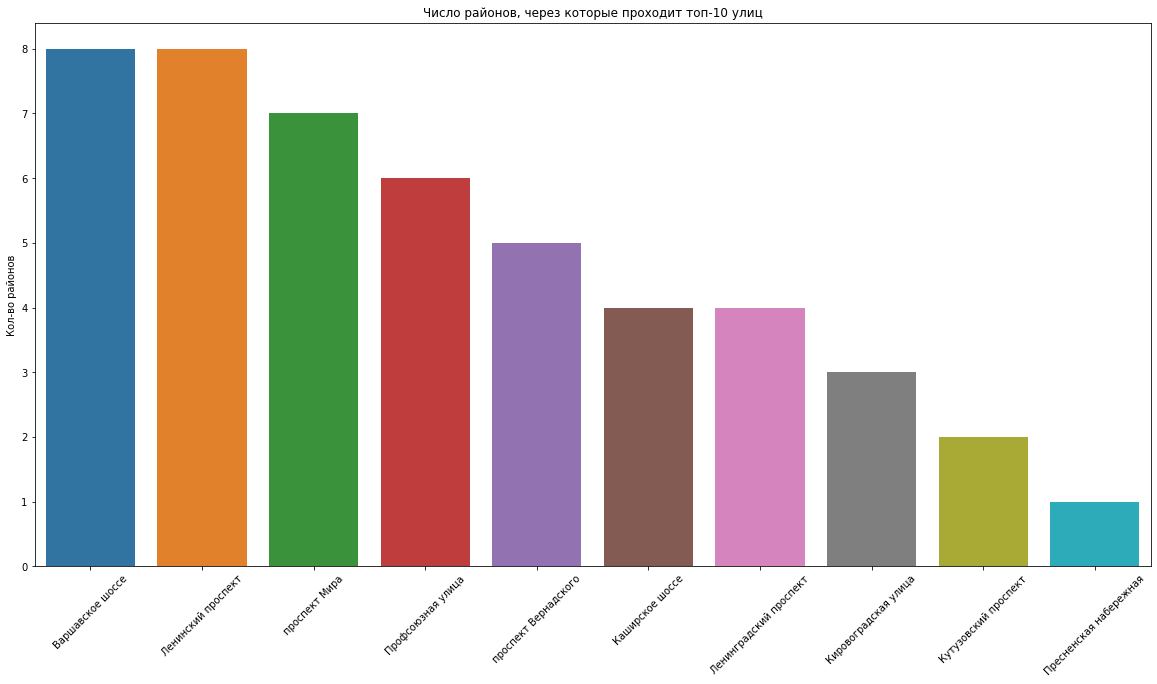

In [35]:
plt.figure(figsize=(20, 10))
sns.barplot(data=top10_pivot.reset_index()
            .groupby('street')['area'].count().reset_index()
            .sort_values(by='area', ascending=False), x='street', y='area')
plt.xticks(rotation=45)
plt.title('Число районов, через которые проходит топ-10 улиц')
plt.xlabel('')
plt.ylabel('Кол-во районов')
plt.show()

### Найдём число улиц с одним объектом общественного питания и определим, в каких районах Москвы находятся эти улицы

Возьмём датасет object_name_count и локом оставим те строки, в которых число объектов равняется одному и посчитаем кол-во уникальных значений столбца street.

In [36]:
object_name_count[object_name_count['object_name'] == 1]['street'].nunique()

551

Всего 551 улица с одним объектом общепита.

In [37]:
object_name_count = object_name_count.merge(streets, on='street', how='left')
object_name_count['area'].value_counts().to_frame()

,area
Тверской район,106
Пресненский район,87
Таганский район,81
Басманный район,80
Район Хамовники,74
...,...
Район Братеево,5
Район Новокосино,4
Район Некрасовка,2
Район Восточный,2


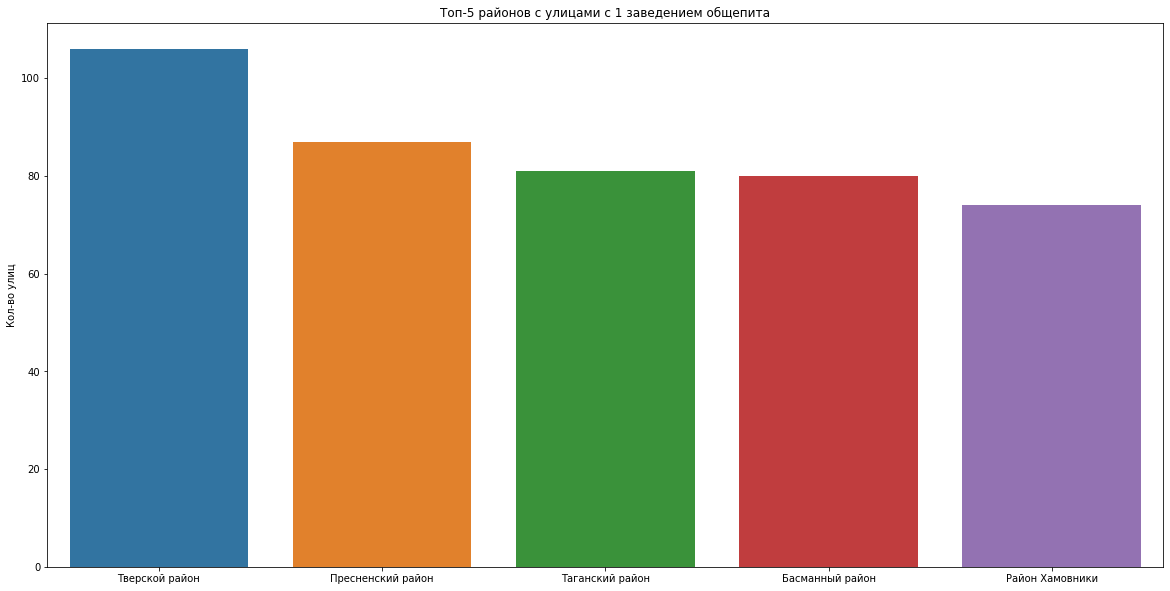

In [38]:
plt.figure(figsize=(20, 10))
sns.barplot(data = object_name_count['area'].value_counts().reset_index().head(5), x='index', y='area')
plt.title('Топ-5 районов с улицами с 1 заведением общепита')
plt.xlabel('')
plt.ylabel('Кол-во улиц')
plt.show()

Мы выяснили, что в Москве всего 123 района, на которых расположено всего одно заведение общепита. В топ-5 районов с такими улицами входят Тверской, Пресненский, Таганский, Басманный и Хамовники. Все эти районы объединяет то, что они являются частью Центрального административного округа г. Москвы. Вероятно, то обстоятельство, что в этих районах много улиц, на которых располагается всего одно заведение, связано, во-первых, с высокой арендной платой, а во-вторых, с большим количеством небольших тихих улочек, на которых, возможно, не будет нужной проходимости для окупаемости заведения.

### Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания


Сначала извлечём названия улиц из top10 и сделаем из названий словарь.

In [39]:
top10streets = top10['street'].unique().astype(str)
top10streets

array(['проспект Мира', 'Профсоюзная улица', 'Ленинградский проспект',
       'Пресненская набережная', 'Варшавское шоссе', 'Ленинский проспект',
       'проспект Вернадского', 'Кутузовский проспект', 'Каширское шоссе',
       'Кировоградская улица'], dtype='<U22')

Теперь сделаем срез данных по общей таблице на основе созданного словаря и построим гистограмму.

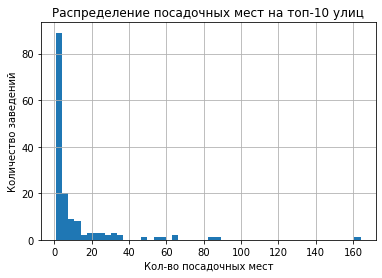

In [40]:
data_top10_streets = data.query('street in @top10streets')
data_top10_streets['number'].value_counts().hist(bins=50)
plt.title('Распределение посадочных мест на топ-10 улиц')
plt.xlabel('Кол-во посадочных мест')
plt.ylabel('Количество заведений')
plt.show()

Гистрограмма показывает, что в топе улиц по кол-ву заведений бОльшая их часть не имеет посадочных мест. В целом видно, что чем больше посадочных мест, тем больше кол-во заведений. Также посмотрим медианное значение количества посадочных мест, предварительно исключив значение 0.

In [41]:
median_seats = data_top10_streets[data_top10_streets['number'] > 0]
median_seats['number'].median()

40.0

Итак, чаще всего встречаются кафе с приблизительно 40 посадочными местами. Именно на эту цифру мы предлагаем ориентироваться при открытии.

## Общий вывод.

Нашей целью было проанализировать рынок общественного питания в Москве. Перед нами была поставлена цель выяснить, имеет ли смысл открывать общепит с роботами. Для достижения этой цели мы оптимизировали имеюющиеся у нас данные, унифицировав названия заведений, проверив на ошибки и повторы.

В основной части нашего исследования мы пришли к следующим выводам:
- Наибольшее кол-во заведений составляют кафе - их около 6 000. За ними идут столовые, рестораны и предприятия быстрого обслуживания. Меньше всего заведений в магазинах (отдел кулинарии).
- На рынке общепита доминируют несетевые заведения - их более чем в 3 раза больше, чем сетевых.
- Из сетевых заведений лидером является кафе, затем идут предприятия быстрого питания и рестораны. Аутсайдером здесь являются столовые.
- Из сетевых заведений больше тех, у которых небольшое кол-во посадочных мест, и меньше заведений с большим их кол-вом.
- В рейтинге среднего числа посадочных мест по всем заведениям лидируют столовые. За ними идут рестораны и буфеты. В самом конце рейтинга расположились отделы кулинарии в магазинах.
- В топ-10 улиц с наибольшим кол-вом заведений общепита вошли: проспект Мира, Профсоюзная улица, Ленинградский проспект, Пресненская набережная, Варшавское шоссе, Ленинский проспект, проспект Вернадского, Кутузовский проспект, Каширское шоссе и Кировоградская улица.
- Каждая из этих улиц проходит через несколько районов, что неудивительно ввиду их протяжённости.
- В Москве 551 улица, на которой находится всего одно заведение. Больше всего таких улиц в Тверском районе.
- Очень чётко прослеживается закономерность, согласно которой чем больше посадочных мест, тем больше заведений общепита.
- Больше всего заведений без посадочных мест: это могут быть палатки с шаурмой или кофе to go.

На основе этих данных мы могли бы дать следующие рекомендации:
- В качестве типа заведения выбрать кафе ввиду их наибольшей распространённости и бОльшей доступности.
- Выбирать место ближе к центру города и/или к проходимым местам. Не рекомендуем размещать заведение на окраине из-за специфичного формата заведения (роботы).
- Рекомендуем ориентироваться на приблизительно 40 посадочных мест.